In [10]:
import pandas as pd
from sklearn import preprocessing, ensemble

In [6]:
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')
test = pd.read_csv('assets/west-nile-test.csv')
train = pd.read_csv('assets/west-nile-train.csv')

In [8]:
# Get labels
labels = train['WnvPresent'].values

# Not using codesum for this benchmark
weather = weather.drop('CodeSum', axis=1)

# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)

# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)

# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)

# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

# drop columns with -1s
train = train.ix[:,(train != -1).any(axis=0)]
test = test.ix[:,(test != -1).any(axis=0)]


In [113]:
train.columns[-13:]

Index([u'Tmax_y', u'Tmin_y', u'Tavg_y', u'DewPoint_y', u'WetBulb_y', u'Heat_y',
       u'Cool_y', u'PrecipTotal_y', u'StnPressure_y', u'SeaLevel_y',
       u'ResultSpeed_y', u'ResultDir_y', u'AvgSpeed_y'],
      dtype='object')

In [36]:
pd.Series(labels).value_counts()

0    9955
1     551
dtype: int64

In [37]:
from sklearn import model_selection

In [132]:
train_train, train_test, labels_train, labels_test = model_selection.train_test_split(train, labels, test_size=.3)

In [126]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000)
clf.fit(train_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [127]:
predict = clf.predict_proba(train_test)

In [131]:
metrics.roc_auc_score(labels_test, predict[:,1])

0.78661719900037652

In [129]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000)
clf.fit(train_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [130]:
pd.DataFrame(clf.feature_importances_, train_train.columns).sort_values(by=0, ascending=False)

0
Species          0.167593
Longitude        0.126225
Trap             0.122961
Latitude         0.115783
Street           0.109399
Block            0.094245
AddressAccuracy  0.034708
Sunset_x         0.019963
Sunrise_x        0.019094
month            0.009846
ResultDir_y      0.008568
AvgSpeed_x       0.008369
ResultDir_x      0.007960
Tmax_x           0.007775
ResultSpeed_x    0.007380
day              0.007368
Tmax_y           0.007304
ResultSpeed_y    0.007117
WetBulb_x        0.007047
Tmin_x           0.006957
DewPoint_y       0.006951
DewPoint_x       0.006833
Cool_x           0.006758
Tavg_x           0.006739
AvgSpeed_y       0.006706
Depart_x         0.006542
Tmin_y           0.006523
Tavg_y           0.006325
Cool_y           0.006285
StnPressure_x    0.005983
SeaLevel_x       0.005955
SeaLevel_y       0.005930
StnPressure_y    0.005649
WetBulb_y        0.005642
Lat_int          0.005450
PrecipTotal_y    0.005404
PrecipTotal_x    0.003988
Heat_x           0.000421
Heat_y           0.000252
SnowFall_x       0.000001
Long_int         0.000000
Depth_x          0.000000

In [91]:
predict = clf.predict_proba(test)

In [92]:
sample_submission = pd.read_csv('assets/sampleSubmission.csv')

In [93]:
sample_submission.WnvPresent = predict[:,1]

In [94]:
sample_submission.head()

Id  WnvPresent
0   1    0.017953
1   2    0.011150
2   3    0.016700
3   4    0.011150
4   5    0.011150

In [95]:
sample_submission.to_csv('assets/trialSubmission.csv', index=False)

In [83]:
metrics.roc_auc_score(labels, predict[:,1])

0.99110643995985559

In [51]:
from sklearn import metrics

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
metrics.accuracy_score(labels_test, predict)

0.94257614213197971

In [54]:
print metrics.classification_report(labels_test, predict)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2985
          1       0.38      0.13      0.20       167

avg / total       0.92      0.94      0.93      3152



In [13]:
pd.options.display.max_columns=100
train

Species  Block  Street  Trap   Latitude  Longitude  AddressAccuracy  \
0            2     41      36     1  41.954690 -87.800991                9   
1            3     41      36     1  41.954690 -87.800991                9   
2            3     62      30     8  41.994991 -87.769279                9   
3            2     79     120    15  41.974089 -87.824812                8   
4            3     79     120    15  41.974089 -87.824812                8   
5            3     15     138    34  41.921600 -87.666455                8   
6            3     25     123    35  41.891118 -87.654491                8   
7            2     11     134    37  41.867108 -87.654224                8   
8            3     11     134    37  41.867108 -87.654224                8   
9            3     11     117    38  41.896282 -87.655232                8   
10           2     21      45    39  41.919343 -87.694259                8   
11           2     22      18    41  41.921965 -87.632085                8   
12           3     22      18    41  41.921965 -87.632085                8   
13           2     22      95    68  41.688324 -87.676709                8   
14           3     22      95    68  41.688324 -87.676709                8   
15           3     11      81    75  41.862292 -87.648860                8   
16           3     17     112    77  41.720848 -87.666014                9   
17           3     22     111    80  41.731922 -87.677512                8   
18           1     22     111    80  41.731922 -87.677512                8   
19           2     53      46    91  41.891126 -87.611560                5   
20           3     53      46    91  41.891126 -87.611560                5   
21           2     65      36    96  41.999129 -87.795585                8   
22           2     75      37   101  42.017430 -87.687769                8   
23           3     15      29   106  41.907645 -87.760886                8   
24           3     89      57   112  41.732984 -87.649642                8   
25           2     41      36     1  41.954690 -87.800991                9   
26           3     41      36     1  41.954690 -87.800991                9   
27           1     41      36     1  41.954690 -87.800991                9   
28           2     79     120    15  41.974089 -87.824812                8   
29           3     79     120    15  41.974089 -87.824812                8   
...        ...    ...     ...   ...        ...        ...              ...   
10476        2     10      62    84  41.750498 -87.605294                5   
10477        3     10      62    84  41.750498 -87.605294                5   
10478        1     10      62    84  41.750498 -87.605294                5   
10479        1     58      40    21  41.984809 -87.728492                8   
10480        2     40       5   129  41.659112 -87.538693                8   
10481        3     40       5   129  41.659112 -87.538693                8   
10482        1     40       5   129  41.659112 -87.538693                8   
10483        3     91     127    10  41.992478 -87.862995                8   
10484        2     10     132   147  41.974689 -87.890615                9   
10485        2     10     132   147  41.974689 -87.890615                9   
10486        1     10     132   147  41.974689 -87.890615                9   
10487        1     10     132   147  41.974689 -87.890615                9   
10488        1     10     132   147  41.974689 -87.890615                9   
10489        1     10     132   147  41.974689 -87.890615                9   
10490        2     48     129   130  41.925198 -87.746381                8   
10491        2     51      34   131  41.973845 -87.805059                9   
10492        1     51      34   131  41.973845 -87.805059                9   
10493        2     82      72   133  41.743402 -87.731435                8   
10494        2     65       9   135  41.728495 -87.600963                5   
10495        1     65       9

In [62]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null datetime64[ns]
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [66]:
spray

Date        Time   Latitude  Longitude
0     2011-08-29  6:56:58 PM  42.391623 -88.089163
1     2011-08-29  6:57:08 PM  42.391348 -88.089163
2     2011-08-29  6:57:18 PM  42.391022 -88.089157
3     2011-08-29  6:57:28 PM  42.390637 -88.089158
4     2011-08-29  6:57:38 PM  42.390410 -88.088858
5     2011-08-29  6:57:48 PM  42.390395 -88.088315
6     2011-08-29  6:57:58 PM  42.390673 -88.088002
7     2011-08-29  6:58:08 PM  42.391027 -88.088002
8     2011-08-29  6:58:18 PM  42.391403 -88.088003
9     2011-08-29  6:58:28 PM  42.391718 -88.087995
10    2011-08-29  6:58:38 PM  42.392038 -88.087988
11    2011-08-29  6:58:48 PM  42.392410 -88.088078
12    2011-08-29  6:58:58 PM  42.392800 -88.088332
13    2011-08-29  6:59:08 PM  42.393257 -88.088370
14    2011-08-29  6:59:18 PM  42.393600 -88.088232
15    2011-08-29  7:00:08 PM  42.393203 -88.088417
16    2011-08-29  7:00:18 PM  42.392792 -88.088312
17    2011-08-29  7:00:28 PM  42.392477 -88.088210
18    2011-08-29  7:00:38 PM  42.392385 -88.088697
19    2011-08-29  7:00:48 PM  42.392098 -88.089113
20    2011-08-29  7:00:58 PM  42.392180 -88.089498
21    2011-08-29  7:01:08 PM  42.392428 -88.089790
22    2011-08-29  7:01:18 PM  42.392722 -88.090042
23    2011-08-29  7:01:28 PM  42.392958 -88.090300
24    2011-08-29  7:01:38 PM  42.392990 -88.090895
25    2011-08-29  7:01:48 PM  42.393002 -88.091612
26    2011-08-29  7:01:58 PM  42.393008 -88.092010
27    2011-08-29  7:02:08 PM  42.393020 -88.092548
28    2011-08-29  7:02:18 PM  42.393103 -88.093182
29    2011-08-29  7:02:28 PM  42.393118 -88.093737
...          ...         ...        ...        ...
14805 2013-09-05  8:28:41 PM  42.009215 -87.815097
14806 2013-09-05  8:28:51 PM  42.008713 -87.815108
14807 2013-09-05  8:29:01 PM  42.008163 -87.815073
14808 2013-09-05  8:29:11 PM  42.007722 -87.815087
14809 2013-09-05  8:29:21 PM  42.007200 -87.815078
14810 2013-09-05  8:29:31 PM  42.006698 -87.815073
14811 2013-09-05  8:29:41 PM  42.006262 -87.815047
14812 2013-09-05  8:29:51 PM  42.006235 -87.814400
14813 2013-09-05  8:30:01 PM  42.006277 -87.813815
14814 2013-09-05  8:30:11 PM  42.006818 -87.813775
14815 2013-09-05  8:30:21 PM  42.007355 -87.813768
14816 2013-09-05  8:30:31 PM  42.007818 -87.813775
14817 2013-09-05  8:30:41 PM  42.008387 -87.813745
14818 2013-09-05  8:30:51 PM  42.008933 -87.813720
14819 2013-09-05  8:31:01 PM  42.009487 -87.813683
14820 2013-09-05  8:31:11 PM  42.010087 -87.813695
14821 2013-09-05  8:31:21 PM  42.010682 -87.813713
14822 2013-09-05  8:31:31 PM  42.011213 -87.813688
14823 2013-09-05  8:31:51 PM  42.011340 -87.812347
14824 2013-09-05  8:33:11 PM  42.010135 -87.812330
14825 2013-09-05  8:33:21 PM  42.009693 -87.812338
14826 2013-09-05  8:33:31 PM  42.009125 -87.812338
14827 2013-09-05  8:33:41 PM  42.008507 -87.812357
14828 2013-09-05  8:33:51 PM  42.007897 -87.812335
14829 2013-09-05  8:34:01 PM  42.007218 -87.812338
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460

[14835 rows x 4 columns]

In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [6]:
train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [7]:
train.describe(include='all')

Date                                            Address  \
count        10506                                              10506   
unique          95                                                138   
top     2007-08-01  ORD Terminal 5, O'Hare International Airport, ...   
freq           551                                                750   
mean           NaN                                                NaN   
std            NaN                                                NaN   
min            NaN                                                NaN   
25%            NaN                                                NaN   
50%            NaN                                                NaN   
75%            NaN                                                NaN   
max            NaN                                                NaN   

                       Species         Block            Street   Trap  \
count                    10506  10506.000000             10506  10506   
unique                       7           NaN               128    136   
top     CULEX PIPIENS/RESTUANS           NaN   W OHARE AIRPORT   T900   
freq                      4752           NaN               750    750   
mean                       NaN     35.687797               NaN    NaN   
std                        NaN     24.339468               NaN    NaN   
min                        NaN     10.000000               NaN    NaN   
25%                        NaN     12.000000               NaN    NaN   
50%                        NaN     33.000000               NaN    NaN   
75%                        NaN     52.000000               NaN    NaN   
max                        NaN     98.000000               NaN    NaN   

                    AddressNumberAndStreet      Latitude     Longitude  \
count                                10506  10506.000000  10506.000000   
unique                                 138           NaN           NaN   
top     1000  W OHARE AIRPORT, Chicago, IL           NaN           NaN   
freq                                   750           NaN           NaN   
mean                                   NaN     41.841139    -87.699908   
std                                    NaN      0.112742      0.096514   
min                                    NaN     41.644612    -87.930995   
25%                                    NaN     41.732984    -87.760070   
50%                                    NaN     41.846283    -87.694991   
75%                                    NaN     41.954690    -87.627796   
max                                    NaN     42.017430    -87.531635   

        AddressAccuracy  NumMosquitos    WnvPresent  
count      10506.000000  10506.000000  10506.000000  
unique              NaN           NaN           NaN  
top                 NaN           NaN           NaN  
freq                NaN           NaN           NaN  
mean           7.819532     12.853512      0.052446  
std            1.452921     16.133816      0.222936  
min            3.000000      1.000000      0.000000  
25%            8.000000      2.000000      0.000000  
50%            8.000000      5.000000      0.000000  
75%            9.000000     17.000000      0.000000  
max            9.000000     50.000000      1.000000

In [8]:
%matplotlib inline

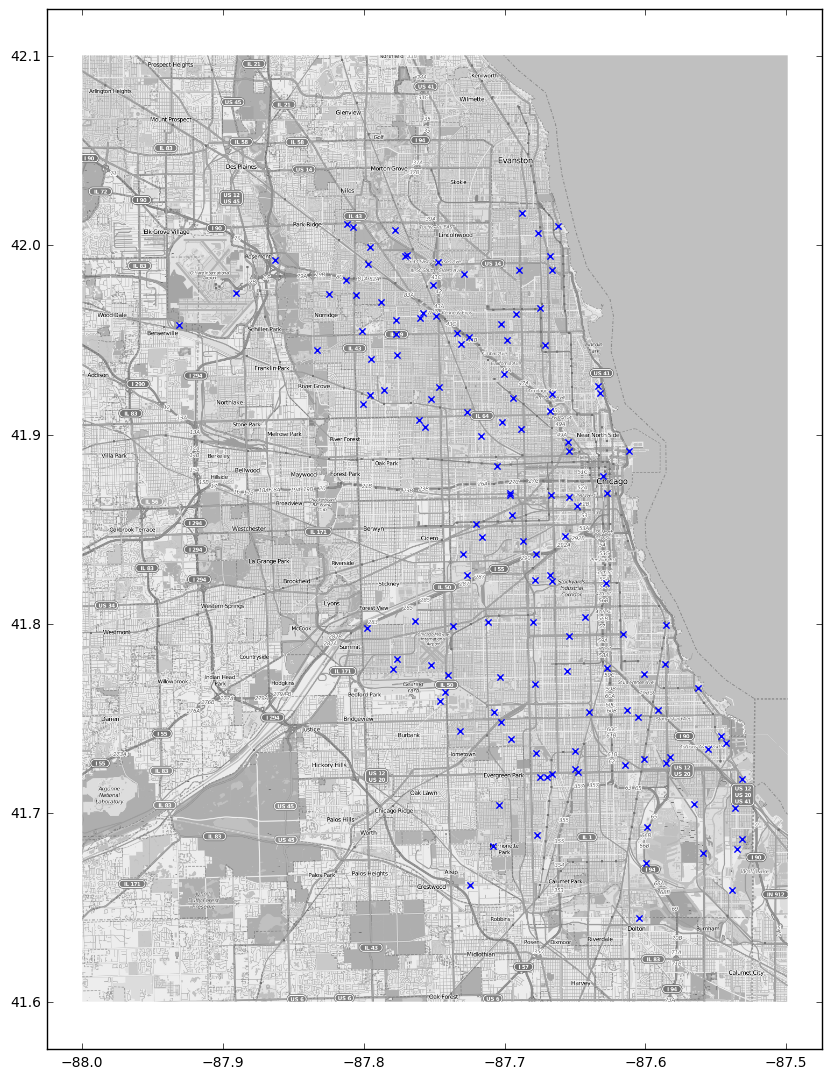

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('assets/west-nile-train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.savefig('heatmap.png')
plt.show()

In [11]:
test.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

In [12]:
spray.Date = pd.to_datetime(spray.Date, format='%Y-%m-%d')

In [13]:
spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [14]:
train.Date = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.Date.describe()

count                   10506
unique                     95
top       2007-08-01 00:00:00
freq                      551
first     2007-05-29 00:00:00
last      2013-09-26 00:00:00
Name: Date, dtype: object

In [15]:
weather.Date = pd.to_datetime(weather.Date, format='%Y-%m-%d')

In [16]:
weather.Date.describe()

count                    2944
unique                   1472
top       2014-08-27 00:00:00
freq                        2
first     2007-05-01 00:00:00
last      2014-10-31 00:00:00
Name: Date, dtype: object

In [17]:
test.Date = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.Date.describe()

count                  116293
unique                     95
top       2012-07-09 00:00:00
freq                     1293
first     2008-06-11 00:00:00
last      2014-10-02 00:00:00
Name: Date, dtype: object

In [18]:
weather.columns

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

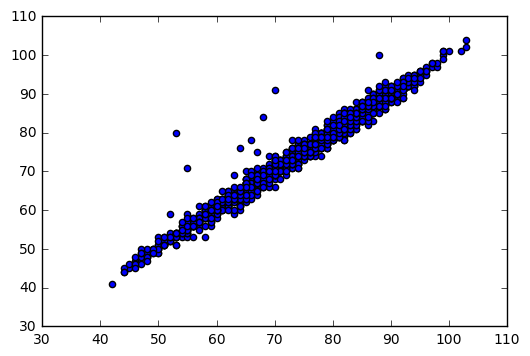

In [19]:
plt.scatter(weather.Tmax[weather.Station == 1], weather.Tmax[weather.Station == 2])

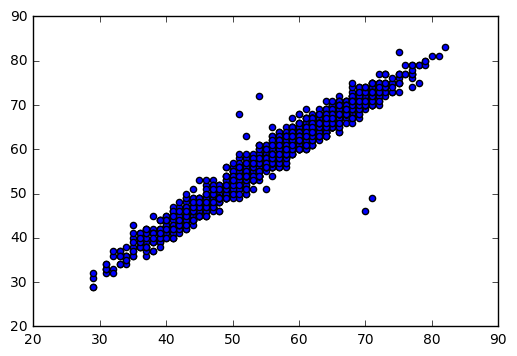

In [20]:
plt.scatter(weather.Tmin[weather.Station == 1], weather.Tmin[weather.Station == 2])

In [21]:
weather.Tavg = pd.to_numeric(weather.Tavg, errors='coerce')

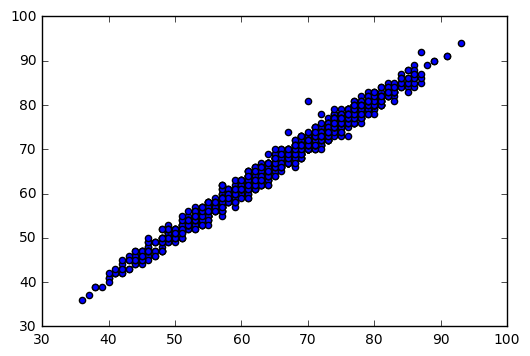

In [22]:
plt.scatter(weather.Tavg[weather.Station == 1], weather.Tavg[weather.Station == 2])

In [23]:
weather.Depart = pd.to_numeric(weather.Depart, errors='coerce')

In [24]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2933 non-null float64
Depart         1472 non-null float64
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(13)
memory usage: 506.1+ KB


In [25]:
#Depart is in one weather station.

In [58]:
weather.head(20)

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0         1 2007-05-01    83    50  67.0    14.0        51     56.0   0.0   
1         2 2007-05-01    84    52  68.0     NaN        51     57.0   0.0   
2         1 2007-05-02    59    42  51.0    -3.0        42     47.0  14.0   
3         2 2007-05-02    60    43  52.0     NaN        42     47.0  13.0   
4         1 2007-05-03    66    46  56.0     2.0        40     48.0   9.0   
5         2 2007-05-03    67    48  58.0     NaN        40     50.0   7.0   
6         1 2007-05-04    66    49  58.0     4.0        41     50.0   7.0   
7         2 2007-05-04    78    51   NaN     NaN        42     50.0   NaN   
8         1 2007-05-05    66    53  60.0     5.0        38     49.0   5.0   
9         2 2007-05-05    66    54  60.0     NaN        39     50.0   5.0   
10        1 2007-05-06    68    49  59.0     4.0        30     46.0   6.0   
11        2 2007-05-06    68    52  60.0     NaN        30     46.0   5.0   
12        1 2007-05-07    83    47  65.0    10.0        41     54.0   0.0   
13        2 2007-05-07    84    50  67.0     NaN        39     53.0   0.0   
14        1 2007-05-08    82    54  68.0    12.0        58     62.0   0.0   
15        2 2007-05-08    80    60  70.0     NaN        57     63.0   0.0   
16        1 2007-05-09    77    61  69.0    13.0        59     63.0   0.0   
17        2 2007-05-09    76    63  70.0     NaN        60     63.0   0.0   
18        1 2007-05-10    84    56  70.0    14.0        52     60.0   0.0   
19        2 2007-05-10    83    59  71.0     NaN        52     61.0   0.0   

    Cool Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  \
0    2.0    0448   1849             0      M      0.0         0.00   
1    3.0       -      -             M      M        M         0.00   
2    0.0    0447   1850      BR     0      M      0.0         0.00   
3    0.0       -      -   BR HZ     M      M        M         0.00   
4    0.0    0446   1851             0      M      0.0         0.00   
5    0.0       -      -      HZ     M      M        M         0.00   
6    0.0    0444   1852      RA     0      M      0.0          NaN   
7    NaN       -      -             M      M        M         0.00   
8    0.0    0443   1853             0      M      0.0          NaN   
9    0.0       -      -             M      M        M          NaN   
10   0.0    0442   1855             0      M      0.0         0.00   
11   0.0       -      -             M      M        M         0.00   
12   0.0    0441   1856      RA     0      M      0.0          NaN   
13   2.0       -      -             M      M        M         0.00   
14   3.0    0439   1857      BR     0      M      0.0         0.00   
15   5.0       -      -      HZ     M      M        M          NaN   
16   4.0    0438   1858   BR HZ     0      M      0.0         0.13   
17   5.0       -      -   BR HZ     M      M        M         0.02   
18   5.0    0437   1859      BR     0      M      0.0         0.00   
19   6.0       -      -   BR HZ     M      M        M         0.00   

    StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0         29.10     29.82          1.7         27       9.2  
1         29.18     29.82          2.7         25       9.6  
2         29.38     30.09         13.0          4      13.4  
3         29.44     30.08         13.3          2      13.4  
4         29.39     30.12         11.7          7      11.9  
5         29.46     30.12         12.9          6      13.2  
6         29.31     30.05         10.4          8      10.8  
7         29.36     30.04         10.1          7      10.4  
8         29.40     30.10         11.7          7      12.0  
9         29.46     30.09         11.2          7      11.5  
10        29.57     30.29         14.4         11      15.0  
11        29.62     30.28         13.8         10      14.5  
12        29.38     30.12          8.6         18      10.5  
13        29.44     30.12          8.5         

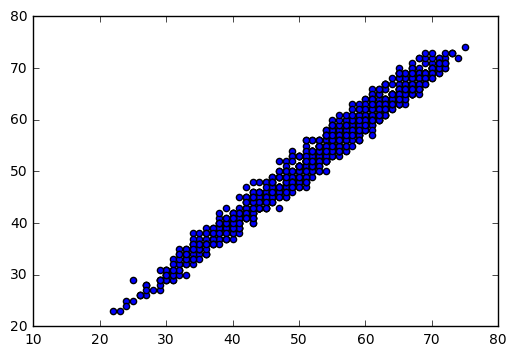

In [27]:
plt.scatter(weather.DewPoint[weather.Station == 1], weather.DewPoint[weather.Station == 2])

In [28]:
weather.WetBulb = pd.to_numeric(weather.WetBulb, errors='coerce')

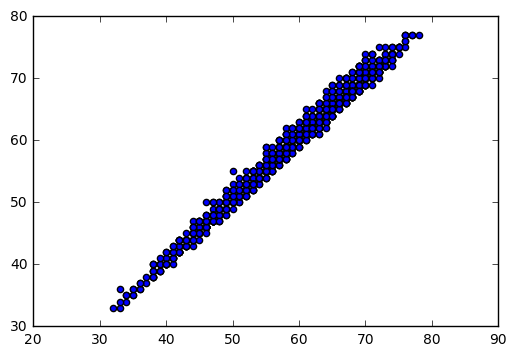

In [42]:
plt.scatter(weather.WetBulb[weather.Station == 1], weather.WetBulb[weather.Station == 2])

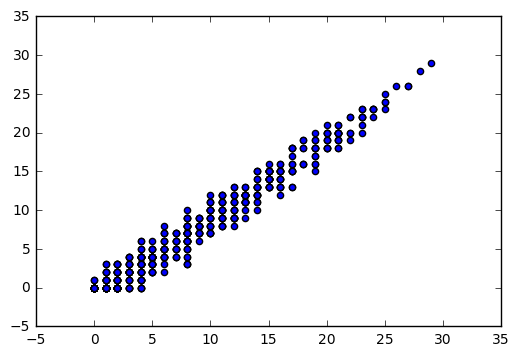

In [43]:
weather.Heat = pd.to_numeric(weather.Heat, errors='coerce')
plt.scatter(weather.Heat[weather.Station == 1], weather.Heat[weather.Station == 2])

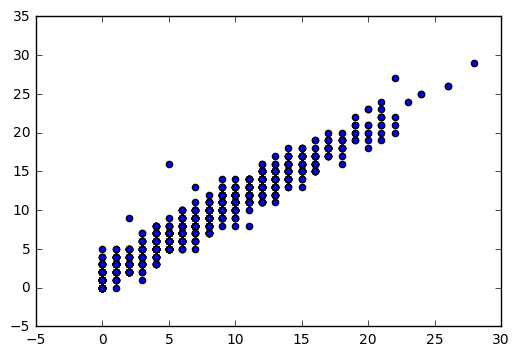

In [44]:
weather.Cool = pd.to_numeric(weather.Cool, errors='coerce')
plt.scatter(weather.Cool[weather.Station == 1], weather.Cool[weather.Station == 2])

In [54]:
weather.PrecipTotal[weather.Station == 1]

0       0.00
2       0.00
4       0.00
6        NaN
8        NaN
10      0.00
12       NaN
14      0.00
16      0.13
18      0.00
20      0.00
22      0.00
24      0.00
26      0.00
28      0.38
30      0.14
32      0.00
34      0.00
36      0.00
38      0.07
40      0.00
42      0.00
44      0.00
46      0.02
48       NaN
50      1.01
52      0.04
54       NaN
56      0.00
58      0.00
        ... 
2884    0.32
2886    0.68
2888    0.06
2890    0.01
2892    0.01
2894     NaN
2896    0.00
2898    0.00
2900    0.00
2902    0.00
2904    0.01
2906    0.64
2908    0.65
2910    0.05
2912     NaN
2914     NaN
2916    0.01
2918    0.00
2920    0.01
2922    0.00
2924    0.00
2926    0.00
2928    0.00
2930    0.00
2932    0.00
2934    0.00
2936     NaN
2938    0.00
2940    0.00
2942    0.03
Name: PrecipTotal, dtype: float64

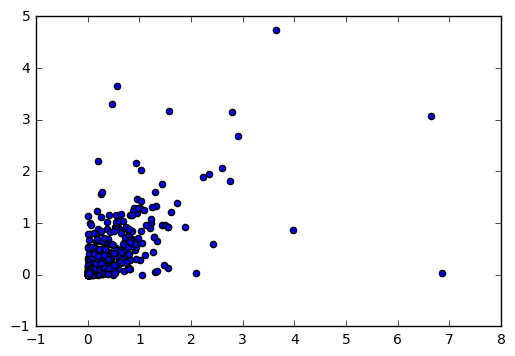

In [45]:
weather.PrecipTotal = pd.to_numeric(weather.PrecipTotal, errors='coerce')
plt.scatter(weather.PrecipTotal[weather.Station == 1], weather.PrecipTotal[weather.Station == 2])

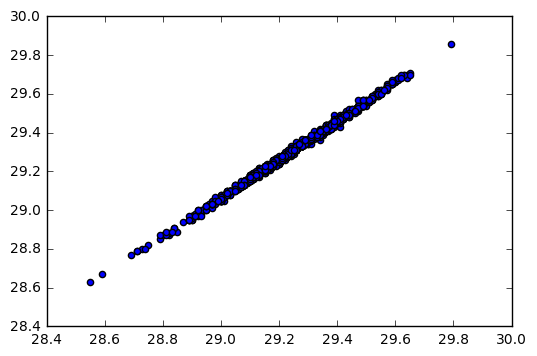

In [49]:
weather.StnPressure = pd.to_numeric(weather.StnPressure, errors='coerce')
plt.scatter(weather.StnPressure[weather.Station == 1], weather.StnPressure[weather.Station == 2])

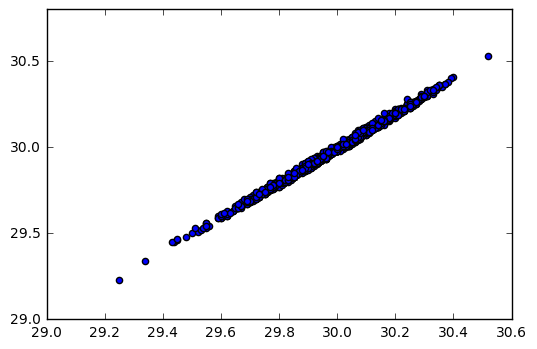

In [50]:
weather.SeaLevel = pd.to_numeric(weather.SeaLevel, errors='coerce')
plt.scatter(weather.SeaLevel[weather.Station == 1], weather.SeaLevel[weather.Station == 2])

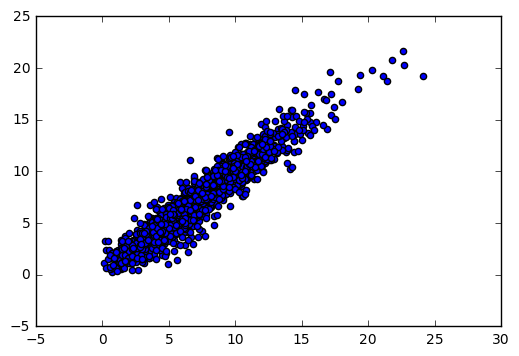

In [51]:
weather.ResultSpeed = pd.to_numeric(weather.ResultSpeed, errors='coerce')
plt.scatter(weather.ResultSpeed[weather.Station == 1], weather.ResultSpeed[weather.Station == 2])

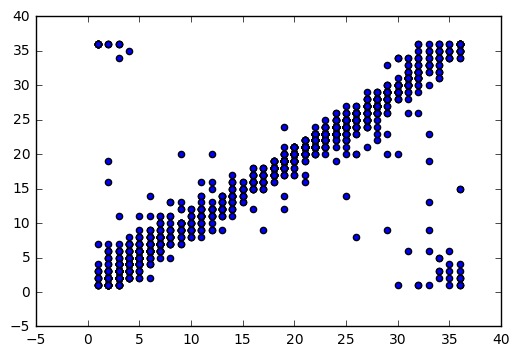

In [52]:
weather.ResultDir = pd.to_numeric(weather.ResultDir, errors='coerce')
plt.scatter(weather.ResultDir[weather.Station == 1], weather.ResultDir[weather.Station == 2])

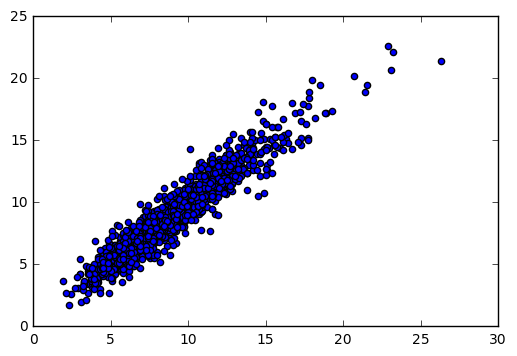

In [53]:
weather.AvgSpeed = pd.to_numeric(weather.AvgSpeed, errors='coerce')
plt.scatter(weather.AvgSpeed[weather.Station == 1], weather.AvgSpeed[weather.Station == 2])

In [47]:
weather[weather.Station==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 22 columns):
Station        1472 non-null int64
Date           1472 non-null datetime64[ns]
Tmax           1472 non-null int64
Tmin           1472 non-null int64
Tavg           1472 non-null float64
Depart         1472 non-null float64
DewPoint       1472 non-null int64
WetBulb        1469 non-null float64
Heat           1472 non-null float64
Cool           1472 non-null float64
Sunrise        1472 non-null object
Sunset         1472 non-null object
CodeSum        1472 non-null object
Depth          1472 non-null object
Water1         1472 non-null object
SnowFall       1472 non-null object
PrecipTotal    1309 non-null float64
StnPressure    1472 non-null object
SeaLevel       1472 non-null object
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null int64
AvgSpeed       1472 non-null object
dtypes: datetime64[ns](1), float64(7), int64(5), object(9)
memory usage: 264.5+ KB


In [48]:
weather[weather.Station==2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 1 to 2943
Data columns (total 22 columns):
Station        1472 non-null int64
Date           1472 non-null datetime64[ns]
Tmax           1472 non-null int64
Tmin           1472 non-null int64
Tavg           1461 non-null float64
Depart         0 non-null float64
DewPoint       1472 non-null int64
WetBulb        1471 non-null float64
Heat           1461 non-null float64
Cool           1461 non-null float64
Sunrise        1472 non-null object
Sunset         1472 non-null object
CodeSum        1472 non-null object
Depth          1472 non-null object
Water1         1472 non-null object
SnowFall       1472 non-null object
PrecipTotal    1315 non-null float64
StnPressure    1472 non-null object
SeaLevel       1472 non-null object
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null int64
AvgSpeed       1472 non-null object
dtypes: datetime64[ns](1), float64(7), int64(5), object(9)
memory usage: 264.5+ KB


In [156]:
weather.CodeSum.values

array([' ', ' ', 'BR', ..., 'RA', 'RA SN', 'RA SN BR'], dtype=object)

In [41]:
np.all(weather.Date[weather.Station==1].values == weather.Date[weather.Station==2].values)

True

In [30]:
weather.Depth.value_counts()
#this column is useless

M    1472
0    1472
Name: Depth, dtype: int64

In [31]:
weather.Water1.value_counts()
#useless

M    2944
Name: Water1, dtype: int64

In [32]:
weather.SnowFall.value_counts()
#useless

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [33]:
weather.SeaLevel.value_counts()

30.00    96
29.94    85
29.98    85
29.92    83
29.89    82
30.05    81
29.95    80
29.91    80
30.02    80
29.93    79
29.96    77
29.97    73
29.99    73
30.03    72
30.01    72
30.04    72
30.06    69
29.87    62
29.90    60
29.86    59
29.85    57
29.88    56
30.08    55
30.10    53
29.83    53
30.11    52
30.07    52
30.09    50
29.84    47
29.82    44
         ..
29.59     7
29.55     6
30.31     6
29.62     6
29.45     4
29.53     4
29.63     4
30.37     4
30.36     4
29.64     3
29.56     3
29.54     3
30.34     3
29.34     2
30.38     2
30.40     2
29.48     2
29.51     2
29.50     2
29.52     2
30.41     1
29.23     1
30.53     1
30.52     1
29.43     1
29.46     1
30.39     1
29.47     1
29.44     1
29.25     1
Name: SeaLevel, dtype: int64

In [55]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null datetime64[ns]
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


In [61]:
train

Date                                            Address  \
0     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2     2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
5     2007-05-29   1500 West Webster Avenue, Chicago, IL 60614, USA   
6     2007-05-29     2500 West Grand Avenue, Chicago, IL 60654, USA   
7     2007-05-29        1100 Roosevelt Road, Chicago, IL 60608, USA   
8     2007-05-29        1100 Roosevelt Road, Chicago, IL 60608, USA   
9     2007-05-29   1100 West Chicago Avenue, Chicago, IL 60642, USA   
10    2007-05-29    2100 North Stave Street, Chicago, IL 60647, USA   
11    2007-05-29    2200 North Cannon Drive, Chicago, IL 60614, USA   
12    2007-05-29    2200 North Cannon Drive, Chicago, IL 60614, USA   
13    2007-05-29     2200 West 113th Street, Chicago, IL 60643, USA   
14    2007-05-29     2200 West 113th Street, Chicago, IL 60643, USA   
15    2007-05-29   1100 South Peoria Street, Chicago, IL 60608, USA   
16    2007-05-29      1700 West 95th Street, Chicago, IL 60643, USA   
17    2007-05-29      2200 West 89th Street, Chicago, IL 60643, USA   
18    2007-05-29      2200 West 89th Street, Chicago, IL 60643, USA   
19    2007-05-29       North Streeter Drive, Chicago, IL 60611, USA   
20    2007-05-29       North Streeter Drive, Chicago, IL 60611, USA   
21    2007-05-29  6500 North Oak Park Avenue, Chicago, IL 60631,...   
22    2007-05-29   7500 North Oakley Avenue, Chicago, IL 60645, USA   
23    2007-05-29     1500 North Long Avenue, Chicago, IL 60651, USA   
24    2007-05-29  8900 South Carpenter Street, Chicago, IL 60620...   
25    2007-06-05  4100 North Oak Park Avenue, Chicago, IL 60634,...   
26    2007-06-05  4100 North Oak Park Avenue, Chicago, IL 60634,...   
27    2007-06-05  4100 North Oak Park Avenue, Chicago, IL 60634,...   
28    2007-06-05    7900 West Foster Avenue, Chicago, IL 60656, USA   
29    2007-06-05    7900 West Foster Avenue, Chicago, IL 60656, USA   
...          ...                                                ...   
10476 2013-09-26       South Cottage Grove Avenue, Chicago, IL, USA   
10477 2013-09-26       South Cottage Grove Avenue, Chicago, IL, USA   
10478 2013-09-26       South Cottage Grove Avenue, Chicago, IL, USA   
10479 2013-09-26    5800 North Pulaski Road, Chicago, IL 60646, USA   
10480 2013-09-26     4000 East 130th Street, Chicago, IL 60633, USA   
10481 2013-09-26     4000 East 130th Street, Chicago, IL 60633, USA   
10482 2013-09-26     4000 East 130th Street, Chicago, IL 60633, USA   
10483 2013-09-26    9100 West Higgins Road, Rosemont, IL 60018, USA   
10484 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10485 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10486 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10487 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10488 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10489 2013-09-26  ORD Terminal 5, O'Hare International Airport, ...   
10490 2013-09-26   4800 West Montana Street, Chicago, IL 60639, USA   
10491 2013-09-26  5100 North Mont Clare Avenue, Chicago, IL 6065...   
10492 2013-09-26  5100 North Mont Clare Avenue, Chicago, IL 6065...   
10493 2013-09-26  8200 South Kostner Avenue, Chicago, IL 60652, USA   
10494 2013-09-26                  East 91st Place, Chicago, IL, USA   
10495 2013-09-26                  East 91st Place, Chicago, IL, USA   
10496 2013-09-26   1700 West Addison Street, Chicago, IL 60613, USA   
10497 2013-09-26          West Garfield Boulevard, Chicago, IL, USA   
10498 2013-09-26  1300 North Laramie Avenue, Chicago, IL 60651, USA   
10499 2013-09-26  1300 North Laramie Avenue, Chicago, IL 60651, USA   
10500 2013-09-26  3900 North Springf

In [34]:
weather_train = pd.merge(train, weather, how='outer', left_on=train.Date, right_on=weather.Date)
weather_train_spray = pd.merge(weather_train, spray, how='outer', left_on=weather_train.Date_x, right_on=spray.Date, )
weather_train_spray.columns

Index([u'Date_x', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude_x', u'Longitude_x',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'Station',
       u'Date_y', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed', u'Date',
       u'Time', u'Latitude_y', u'Longitude_y'],
      dtype='object')

In [68]:
spray[spray.Date=='2011-08-29'].head()

Date        Time   Latitude  Longitude
0 2011-08-29  6:56:58 PM  42.391623 -88.089163
1 2011-08-29  6:57:08 PM  42.391348 -88.089163
2 2011-08-29  6:57:18 PM  42.391022 -88.089157
3 2011-08-29  6:57:28 PM  42.390637 -88.089158
4 2011-08-29  6:57:38 PM  42.390410 -88.088858

In [93]:
train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [76]:
import seaborn as sns

In [80]:
spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [88]:
from matplotlib import cm

In [108]:
locations = train[['Longitude', 'Latitude']]
print 'min long:', locations.Longitude.min()
print 'max long:', locations.Longitude.max()
print 'min lat:', locations.Latitude.min()
print 'max lat:', locations.Latitude.max()

min long: -87.930995
max long: -87.531635
min lat: 41.644612
max lat: 42.01743


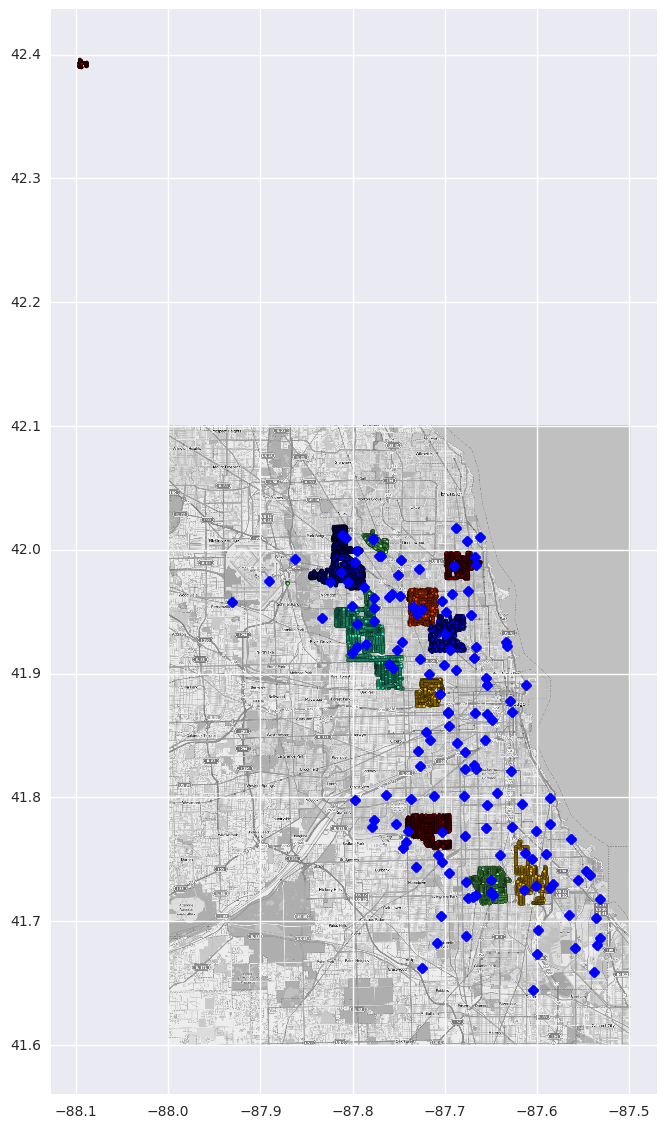

In [114]:
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


plt.scatter(spray.Longitude, spray.Latitude, marker='.', c=spray.Date.apply(lambda x: x.day), cmap=cm.jet)

locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', linewidths=5)

plt.savefig('heatmap.png')
plt.show()

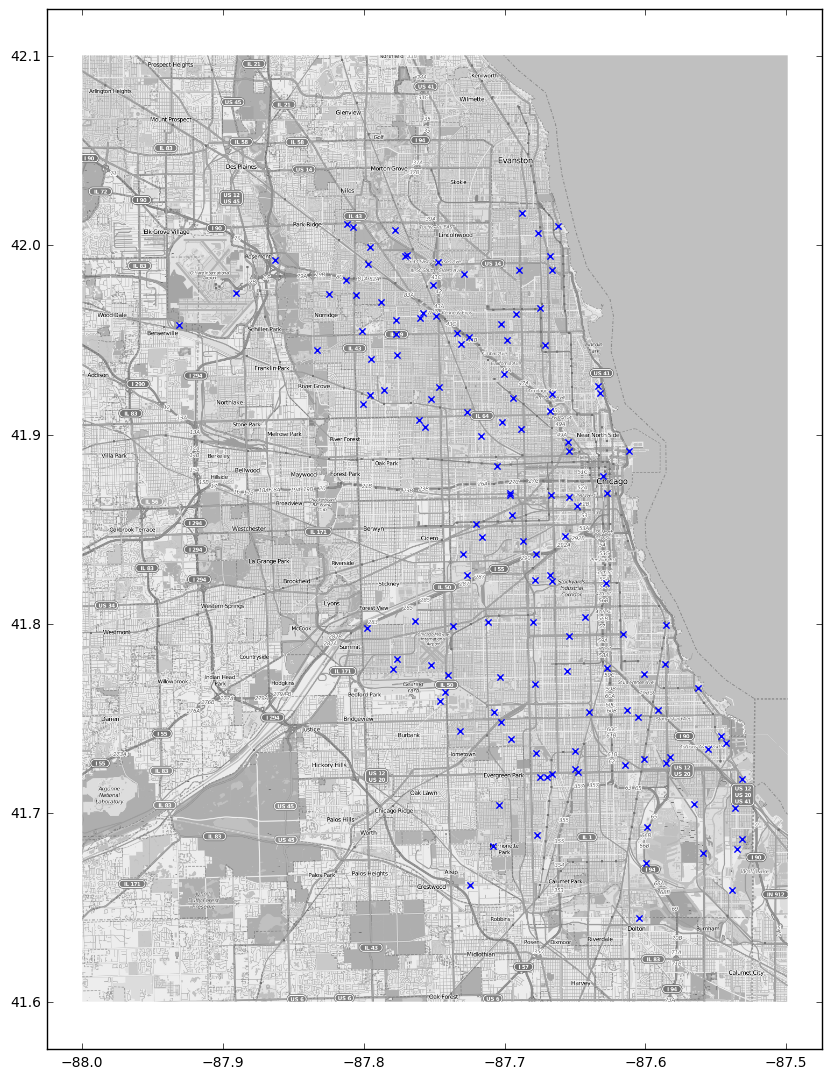

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('assets/west-nile-train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.savefig('heatmap.png')
plt.show()

In [135]:
def avg_wind_direction(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    elif np.abs(S1-S2) > 18:
        if S1<S2:
            S1+=36
        else:
            S2+=36
        avg = (S1+S2)/2.0
    else:
        avg = (S1+S2)/2.0
    if avg >=36:
        avg-=36
    return avg

In [168]:
def combine_conditions(S1, S2):
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " " and S2 != " ":
        return S2
    elif S1 != " " and S2 == " ":
        return S1
    else:
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))

In [192]:
def avg_col(S1, S2):
   if S1 == np.NaN:
       avg = float(S2)
   elif S2 == np.NaN:
       avg = float(S1)
   else: 
       avg=(S1+S2)/2.0
   return avg

In [196]:
combined_weather = pd.DataFrame()
combined_weather['Date'] = weather.Date[weather.Station==1].values
combined_weather['ResultDir'] = [avg_wind_direction(a, b) for a, b in zip(weather.ResultDir[weather.Station==1].values, weather.ResultDir[weather.Station==2].values)]
combined_weather['CodeSum'] = [combine_conditions(a, b) for a, b in zip(weather.CodeSum[weather.Station==1].values, weather.CodeSum[weather.Station==2].values)]
combined_weather['Depart'] = weather.Depart[weather.Station==1].values
combined_weather['Sunrise'] = weather.Sunrise[weather.Station==1].values
combined_weather['Sunset'] = weather.Sunset[weather.Station==1].values
combined_weather['PrecipTotal_station1'] = weather.PrecipTotal[weather.Station==1].values
combined_weather['PrecipTotal_station2'] = weather.PrecipTotal[weather.Station==2].values
for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed']:
    combined_weather[col] = [avg_col(a, b) for a, b in zip(weather[col][weather.Station==1].values, weather[col][weather.Station==2].values)]

In [197]:
combined_weather.head()

Date  ResultDir   CodeSum  Depart Sunrise Sunset  \
0 2007-05-01       26.0              14.0    0448   1849   
1 2007-05-02        3.0  [HZ, BR]    -3.0    0447   1850   
2 2007-05-03        6.5        HZ     2.0    0446   1851   
3 2007-05-04        7.5        RA     4.0    0444   1852   
4 2007-05-05        7.0               5.0    0443   1853   

   PrecipTotal_station1  PrecipTotal_station2  Tmax  Tmin  Tavg  DewPoint  \
0                   0.0                   0.0  83.5  51.0  67.5      51.0   
1                   0.0                   0.0  59.5  42.5  51.5      42.0   
2                   0.0                   0.0  66.5  47.0  57.0      40.0   
3                   NaN                   0.0  72.0  50.0   NaN      41.5   
4                   NaN                   NaN  66.0  53.5  60.0      38.5   

   WetBulb  Heat  Cool  StnPressure  SeaLevel  ResultSpeed  AvgSpeed  
0     56.5   0.0   2.5       29.140    29.820         2.20      9.40  
1     47.0  13.5   0.0       29.410    30.085        13.15     13.40  
2     49.0   8.0   0.0       29.425    30.120        12.30     12.55  
3     50.0   NaN   NaN       29.335    30.045        10.25     10.60  
4     49.5   5.0   0.0       29.430    30.095        11.45     11.75

In [198]:
train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [201]:
weather_train_merged = pd.merge(train, combined_weather, how='outer', left_on='Date', right_on='Date')

In [203]:
list(weather_train_merged.columns)

['Date',
 'Address',
 'Species',
 'Block',
 'Street',
 'Trap',
 'AddressNumberAndStreet',
 'Latitude',
 'Longitude',
 'AddressAccuracy',
 'NumMosquitos',
 'WnvPresent',
 'ResultDir',
 'CodeSum',
 'Depart',
 'Sunrise',
 'Sunset',
 'PrecipTotal_station1',
 'PrecipTotal_station2',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'AvgSpeed']

In [329]:
gp = weather_train_merged[['Date', 'Depart', 'Tmin', 'WnvPresent', 'NumMosquitos', 'WetBulb', 'ResultSpeed', 'Heat', 'Cool']].dropna().groupby(['Date'])

In [330]:
date_by_mosq = gp.aggregate({'WnvPresent': 'sum',
                            'NumMosquitos': 'sum',
                            'WetBulb':'mean',
                            'ResultSpeed': 'mean', 
                            'Heat': 'mean',
                            'Cool': 'mean',
                            'Tmin':'mean',
                            'Depart':'mean',})

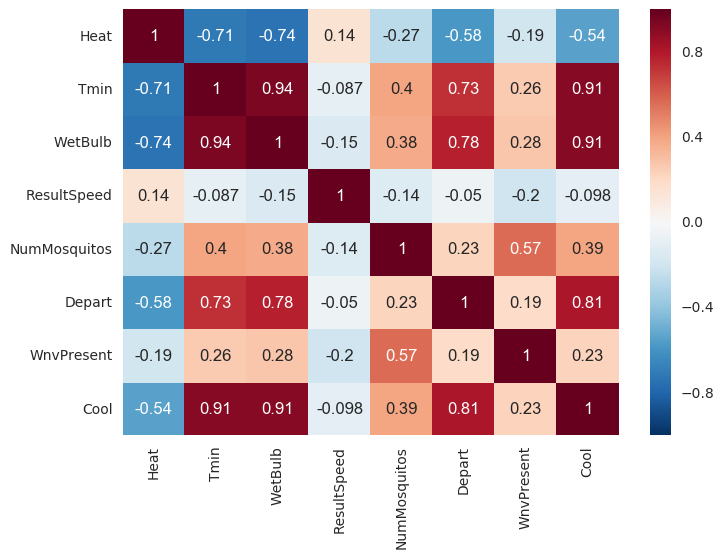

In [332]:
import seaborn as sns
sns.heatmap(date_by_mosq.corr(), annot=True)

In [339]:
gp2 = weather_train_merged[['Trap', 'Longitude', 'Latitude','WnvPresent', 'NumMosquitos']].dropna().groupby(['Trap', 'Longitude', 'Latitude'])

In [340]:
trap_by_mosq = gp2.agg('sum')

In [341]:
trap_by_mosq.corr()

WnvPresent  NumMosquitos
WnvPresent      1.000000      0.870502
NumMosquitos    0.870502      1.000000

In [343]:
trap_by_mosq['pct_wnv'] = trap_by_mosq.WnvPresent/trap_by_mosq.NumMosquitos
trap_by_mosq

WnvPresent  NumMosquitos   pct_wnv
Trap Longitude  Latitude                                     
T001 -87.733974 41.953705         0.0          25.0  0.000000
T002 -87.800991 41.954690        18.0        3710.0  0.004852
T003 -87.757639 41.964242        14.0        1346.0  0.010401
T004 -87.748367 41.962728         0.0          59.0  0.000000
T005 -87.776385 41.942114         2.0          50.0  0.040000
T006 -87.797127 41.990284         4.0         107.0  0.037383
T007 -87.769279 41.994991         0.0          77.0  0.000000
T008 -87.777921 42.008314        10.0        2668.0  0.003748
T009 -87.862995 41.992478         6.0        1477.0  0.004062
     -87.812827 41.981964         3.0         463.0  0.006479
T011 -87.832763 41.944869        11.0        1311.0  0.008391
T012 -87.747113 41.991429         4.0         952.0  0.004202
T013 -87.785288 41.923738        10.0        1193.0  0.008382
T014 -87.787992 41.970248         4.0         364.0  0.010989
T015 -87.824812 41.974089         4.0         169.0  0.023669
T016 -87.811506 42.011601         7.0         847.0  0.008264
T017 -87.777189 41.960616         0.0         233.0  0.000000
T018 -87.662140 42.010412         0.0         121.0  0.000000
T019 -87.698457 41.949830         0.0          72.0  0.000000
T025 -87.750938 41.979243         0.0          72.0  0.000000
T027 -87.728492 41.984809         7.0         666.0  0.010511
T028 -87.689778 41.986921         9.0        1020.0  0.008824
T030 -87.716788 41.899230         8.0        1802.0  0.004440
T031 -87.763416 41.801498         5.0        1543.0  0.003240
T033 -87.701431 41.906638         5.0         680.0  0.007353
T034 -87.686763 41.843811         0.0          52.0  0.000000
T035 -87.742302 41.763733         2.0         215.0  0.009302
     -87.677737 41.836644         1.0          94.0  0.010638
T036 -87.729384 41.837085         1.0          52.0  0.019231
T037 -87.795180 41.921177         1.0         171.0  0.005848
...                               ...           ...       ...
T160 -87.688267 41.903002         4.0         666.0  0.006006
T161 -87.675088 41.719059         0.0         126.0  0.000000
T162 -87.614258 41.725517         1.0          70.0  0.014286
T200 -87.559308 41.678618         1.0        1368.0  0.000731
T206 -87.543067 41.737052         0.0          65.0  0.000000
T209 -87.546587 41.740641         3.0        1113.0  0.002695
T212 -87.535198 41.680946         3.0        2595.0  0.001156
T215 -87.531635 41.686398         3.0         852.0  0.003521
T218 -87.730698 41.948167         2.0         395.0  0.005063
T219 -87.674677 41.966987         0.0          50.0  0.000000
T220 -87.691810 41.963976         4.0         631.0  0.006339
T221 -87.538693 41.659112         9.0        1699.0  0.005297
T222 -87.746381 41.925198         1.0         300.0  0.003333
T223 -87.805059 41.973845         9.0        1281.0  0.007026
T224 -87.671457 41.947227         1.0         284.0  0.003521
T225 -87.731435 41.743402        11.0        2014.0  0.005462
T226 -87.654234 41.793818         4.0         848.0  0.004717
T227 -87.600963 41.728495         4.0        1179.0  0.003393
T228 -87.725057 41.951866         6.0         643.0  0.009331
T229 -87.639817 41.753411         0.0          28.0  0.000000
T230 -87.756155 41.904194         7.0         644.0  0.010870
T231 -87.666066 41.987280         4.0         521.0  0.007678
T232 -87.668055 41.912563         2.0         286.0  0.006993
T233 -87.807277 42.009876         7.0         758.0  0.009235
T235 -87.627096 41.776428         7.0         557.0  0.012567
T236 -87.770899 41.994679         1.0         375.0  0.002667
T237 -87.695443 41.738903         0.0          18.0  0.000000
T238 -87.707394 41.753391         0.0          34.0  0.000000
T900 -87.890615 41.974689        66.0       15386.0  0.004290
T903 -87.930995 41.957799        10.0        2327.0  0.004297

[138 rows x 3 columns]

In [ ]:
weather_train_merged.pivot_table(
    values=[],
    index=,
    columns=,
    aggfunc=['']
                                )

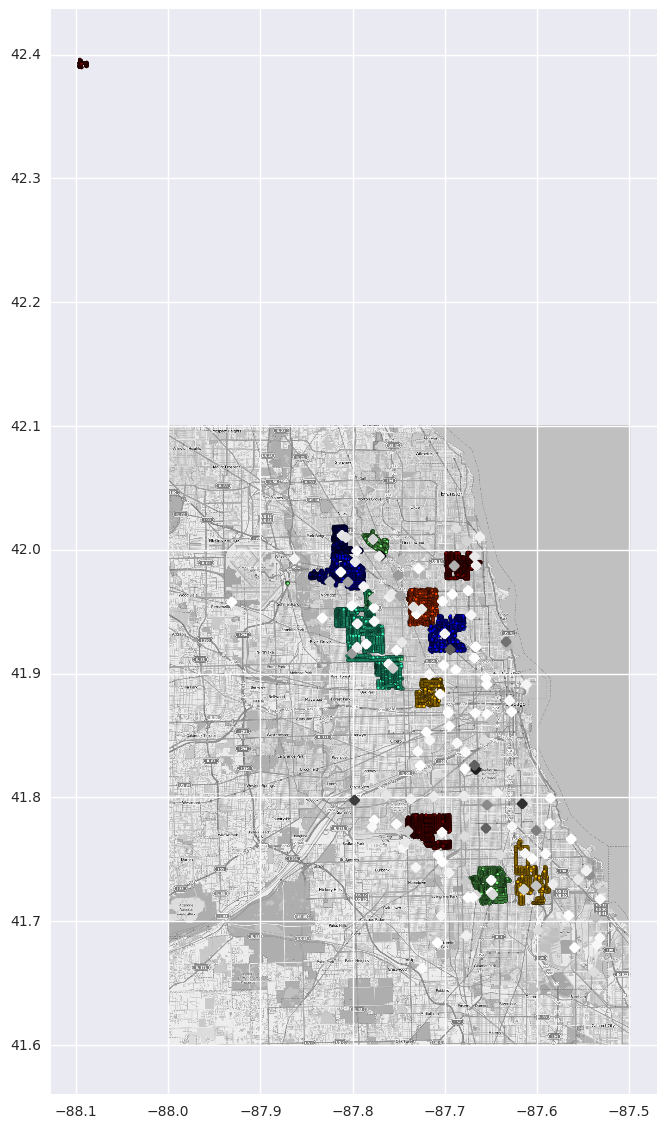

In [351]:
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


plt.scatter(spray.Longitude, spray.Latitude, marker='.', c=spray.Date.apply(lambda x: x.day), cmap=cm.jet)

locations = train[['Longitude', 'Latitude']][(train.Trap != 'T900') & (train.Trap != 'T115') & (train.Trap != 'T138')].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', linewidths=5, c=trap_by_mosq.NumMosquitos[trap_by_mosq.NumMosquitos<4000])

plt.savefig('heatmap.png')
plt.show()

In [350]:
trap_by_mosq.sort_values(by='NumMosquitos', ascending=False)

WnvPresent  NumMosquitos   pct_wnv
Trap  Longitude  Latitude                                     
T115  -87.599862 41.673408        41.0       21668.0  0.001892
T900  -87.890615 41.974689        66.0       15386.0  0.004290
T138  -87.585413 41.726465        16.0        9936.0  0.001610
T002  -87.800991 41.954690        18.0        3710.0  0.004852
T128  -87.565666 41.704572        11.0        3315.0  0.003318
T135  -87.724608 41.662014         8.0        3122.0  0.002562
T103  -87.536497 41.702724         6.0        2988.0  0.002008
T008  -87.777921 42.008314        10.0        2668.0  0.003748
T212  -87.535198 41.680946         3.0        2595.0  0.001156
T158  -87.707973 41.682587         6.0        2575.0  0.002330
T903  -87.930995 41.957799        10.0        2327.0  0.004297
T114  -87.736812 41.798697         9.0        2161.0  0.004165
T225  -87.731435 41.743402        11.0        2014.0  0.005462
T151  -87.800515 41.916265         6.0        1969.0  0.003047
T030  -87.716788 41.899230         8.0        1802.0  0.004440
T048  -87.654224 41.867108         4.0        1796.0  0.002227
T221  -87.538693 41.659112         9.0        1699.0  0.005297
T090  -87.666901 41.868077         7.0        1685.0  0.004154
T031  -87.763416 41.801498         5.0        1543.0  0.003240
T009  -87.862995 41.992478         6.0        1477.0  0.004062
T159  -87.649642 41.732984         4.0        1371.0  0.002918
T200  -87.559308 41.678618         1.0        1368.0  0.000731
T066  -87.703047 41.771660         6.0        1356.0  0.004425
T003  -87.757639 41.964242        14.0        1346.0  0.010401
T086  -87.676709 41.688324         8.0        1312.0  0.006098
T011  -87.832763 41.944869        11.0        1311.0  0.008391
T223  -87.805059 41.973845         9.0        1281.0  0.007026
T094  -87.666014 41.720848         4.0        1197.0  0.003342
T013  -87.785288 41.923738        10.0        1193.0  0.008382
T227  -87.600963 41.728495         4.0        1179.0  0.003393
...                                ...           ...       ...
T129  -87.611560 41.891126         0.0          72.0  0.000000
T077  -87.586427 41.778748         1.0          70.0  0.014286
T162  -87.614258 41.725517         1.0          70.0  0.014286
T050  -87.694259 41.919343         0.0          68.0  0.000000
T206  -87.543067 41.737052         0.0          65.0  0.000000
T071  -87.776532 41.781416         0.0          65.0  0.000000
T156  -87.740029 41.772846         1.0          61.0  0.016393
T004  -87.748367 41.962728         0.0          59.0  0.000000
T142  -87.776792 41.953067         1.0          58.0  0.017241
T150  -87.675919 42.006858         0.0          56.0  0.000000
T034  -87.686763 41.843811         0.0          52.0  0.000000
T036  -87.729384 41.837085         1.0          52.0  0.019231
T075  -87.585487 41.799282         0.0          52.0  0.000000
T219  -87.674677 41.966987         0.0          50.0  0.000000
T005  -87.776385 41.942114         2.0          50.0  0.040000
T157  -87.667827 41.825902         0.0          47.0  0.000000
T094B -87.669539 41.719140         0.0          41.0  0.000000
T141  -87.760070 41.961743         0.0          39.0  0.000000
T044  -87.705085 41.883284         0.0          36.0  0.000000
T238  -87.707394 41.753391         0.0          34.0  0.000000
T051  -87.656913 41.846283         0.0          33.0  0.000000
T229  -87.639817 41.753411         0.0          28.0  0.000000
T001  -87.733974 41.953705         0.0          25.0  0.000000
T076  -87.615989 41.794781         0.0          25.0  0.000000
T060  -87.678378 41.823065         0.0          23.0  0.000000
T072  -87.702716 41.747850         0.0          19.0  0.000000
T237  -87.695443 41.738903         0.0          18.0  0.000000
T078  -87.655356 41.775051         0.0          17.0  0.000000
T149  -87.667736 41.994469         0.0          15.0  0.000000
T040  -87.719887 41.852652         0.0           6.0  0.000000

[138 rows x 3 columns]

In [84]:
train.Date.min()

AttributeError: 'DataFrame' object has no attribute 'Date'